# Decision Trees & LASSO and Boosting for Regression

## 1. Decision Trees as Interpretable Models



a. **Download the Accute Inflammations data** from [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Acute+Inflammations).


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings("ignore")

In [2]:
columns = ['temperature', 'nausea', 'lumbar_pain', 'urine_pushing', 'micturition_pains', 'burning_of_urethra', 'inflammation', 'nephritis']
filepath = '../data/acute+inflammations/diagnosis.data'
data = pd.read_csv(filepath, names=columns, delimiter="\t", encoding='utf-16')
data = data.replace({'no': 0, 'yes': 1})
data['temperature'] = data['temperature'].str.replace(',', '.').astype(float)
data

,temperature,nausea,lumbar_pain,urine_pushing,micturition_pains,burning_of_urethra,inflammation,nephritis
0,35.5,0,1,0,0,0,0,0
1,35.9,0,0,1,1,1,1,0
2,35.9,0,1,0,0,0,0,0
3,36.0,0,0,1,1,1,1,0
4,36.0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...
115,41.4,0,1,1,0,1,0,1
116,41.5,0,0,0,0,0,0,0
117,41.5,1,1,0,1,0,0,1
118,41.5,0,1,1,0,1,0,1



b. **Build a decision tree** on the whole data set and plot it.


Reference: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

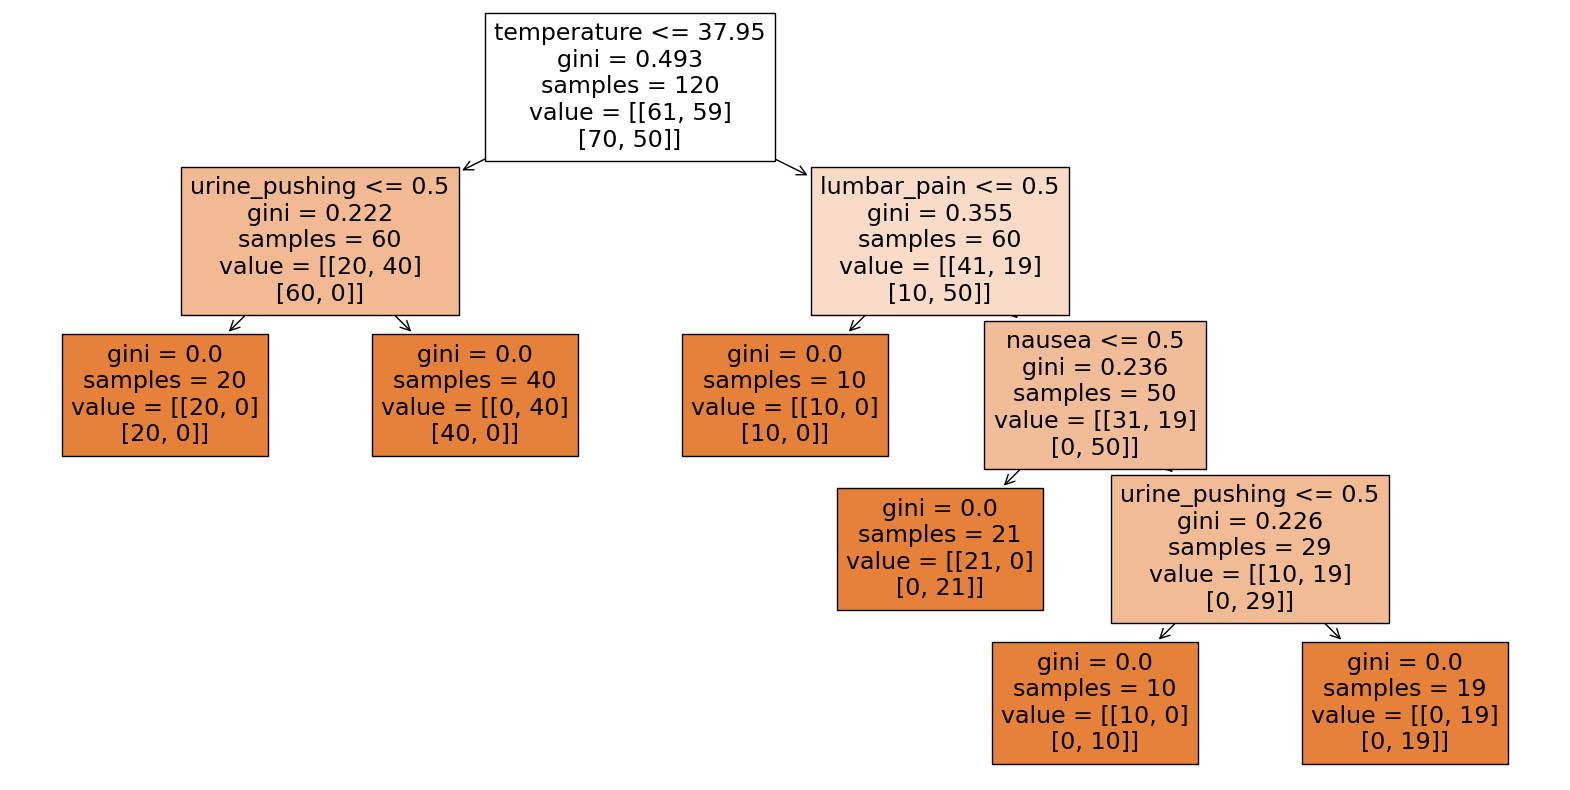

In [3]:
x = data.drop(['inflammation', 'nephritis'], axis=1)
y = data[['inflammation', 'nephritis']]

classifier = DecisionTreeClassifier()
classifier.fit(x, y)

plt.figure(figsize=(20, 10))
plot_tree(classifier, filled=True, feature_names=x.columns)
plt.show()


c. **Convert the decision rules** into a set of IF-THEN rules.


In [4]:
tree_rules = export_text(classifier, feature_names=list(x.columns))

print(tree_rules)

|--- temperature <= 37.95
|   |--- urine_pushing <= 0.50
|   |   |--- class: 0
|   |--- urine_pushing >  0.50
|   |   |--- class: 1
|--- temperature >  37.95
|   |--- lumbar_pain <= 0.50
|   |   |--- class: 0
|   |--- lumbar_pain >  0.50
|   |   |--- nausea <= 0.50
|   |   |   |--- class: 0
|   |   |--- nausea >  0.50
|   |   |   |--- urine_pushing <= 0.50
|   |   |   |   |--- class: 0
|   |   |   |--- urine_pushing >  0.50
|   |   |   |   |--- class: 0




d. **Use cost-complexity pruning** to find a minimal decision tree and a set of decision rules with high interpretability.



In [5]:
tree_path = DecisionTreeClassifier().cost_complexity_pruning_path(x, y)
ccp_alphas, impurities = tree_path.ccp_alphas, tree_path.impurities
# print(ccp_alphas, impurities)

alpha_scores = []
for alpha in ccp_alphas:
    classifier = DecisionTreeClassifier(ccp_alpha=alpha)
    classifier.fit(x, y)
    alpha_scores.append(classifier.score(x, y))

best_alpha = ccp_alphas[np.argmax(alpha_scores)]

print(alpha_scores)
print(f'Best alpha: {best_alpha}')

[1.0, 0.8416666666666667, 0.7583333333333333, 0.5916666666666667, 0.25]
Best alpha: 0.0


In [6]:
classifier_pruned = DecisionTreeClassifier(ccp_alpha=best_alpha)
classifier_pruned.fit(x, y)
tree_rules = export_text(classifier_pruned, feature_names=list(x.columns))
print(tree_rules)

|--- temperature <= 37.95
|   |--- urine_pushing <= 0.50
|   |   |--- class: 0
|   |--- urine_pushing >  0.50
|   |   |--- class: 1
|--- temperature >  37.95
|   |--- lumbar_pain <= 0.50
|   |   |--- class: 0
|   |--- lumbar_pain >  0.50
|   |   |--- micturition_pains <= 0.50
|   |   |   |--- class: 0
|   |   |--- micturition_pains >  0.50
|   |   |   |--- urine_pushing <= 0.50
|   |   |   |   |--- class: 0
|   |   |   |--- urine_pushing >  0.50
|   |   |   |   |--- class: 0



The pruned alpha is 0 (full model), so the tree should look like the original one.


## 2. The LASSO and Boosting for Regression



a. **Download the Communities and Crime data** from [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Communities+and+Crime). Use the first 1495 rows of data as the training set and the rest as the test set.


In [7]:
columns = '''
    @attribute state numeric
    @attribute county numeric
    @attribute community numeric
    @attribute communityname string
    @attribute fold numeric
    @attribute population numeric
    @attribute householdsize numeric
    @attribute racepctblack numeric
    @attribute racePctWhite numeric
    @attribute racePctAsian numeric
    @attribute racePctHisp numeric
    @attribute agePct12t21 numeric
    @attribute agePct12t29 numeric
    @attribute agePct16t24 numeric
    @attribute agePct65up numeric
    @attribute numbUrban numeric
    @attribute pctUrban numeric
    @attribute medIncome numeric
    @attribute pctWWage numeric
    @attribute pctWFarmSelf numeric
    @attribute pctWInvInc numeric
    @attribute pctWSocSec numeric
    @attribute pctWPubAsst numeric
    @attribute pctWRetire numeric
    @attribute medFamInc numeric
    @attribute perCapInc numeric
    @attribute whitePerCap numeric
    @attribute blackPerCap numeric
    @attribute indianPerCap numeric
    @attribute AsianPerCap numeric
    @attribute OtherPerCap numeric
    @attribute HispPerCap numeric
    @attribute NumUnderPov numeric
    @attribute PctPopUnderPov numeric
    @attribute PctLess9thGrade numeric
    @attribute PctNotHSGrad numeric
    @attribute PctBSorMore numeric
    @attribute PctUnemployed numeric
    @attribute PctEmploy numeric
    @attribute PctEmplManu numeric
    @attribute PctEmplProfServ numeric
    @attribute PctOccupManu numeric
    @attribute PctOccupMgmtProf numeric
    @attribute MalePctDivorce numeric
    @attribute MalePctNevMarr numeric
    @attribute FemalePctDiv numeric
    @attribute TotalPctDiv numeric
    @attribute PersPerFam numeric
    @attribute PctFam2Par numeric
    @attribute PctKids2Par numeric
    @attribute PctYoungKids2Par numeric
    @attribute PctTeen2Par numeric
    @attribute PctWorkMomYoungKids numeric
    @attribute PctWorkMom numeric
    @attribute NumIlleg numeric
    @attribute PctIlleg numeric
    @attribute NumImmig numeric
    @attribute PctImmigRecent numeric
    @attribute PctImmigRec5 numeric
    @attribute PctImmigRec8 numeric
    @attribute PctImmigRec10 numeric
    @attribute PctRecentImmig numeric
    @attribute PctRecImmig5 numeric
    @attribute PctRecImmig8 numeric
    @attribute PctRecImmig10 numeric
    @attribute PctSpeakEnglOnly numeric
    @attribute PctNotSpeakEnglWell numeric
    @attribute PctLargHouseFam numeric
    @attribute PctLargHouseOccup numeric
    @attribute PersPerOccupHous numeric
    @attribute PersPerOwnOccHous numeric
    @attribute PersPerRentOccHous numeric
    @attribute PctPersOwnOccup numeric
    @attribute PctPersDenseHous numeric
    @attribute PctHousLess3BR numeric
    @attribute MedNumBR numeric
    @attribute HousVacant numeric
    @attribute PctHousOccup numeric
    @attribute PctHousOwnOcc numeric
    @attribute PctVacantBoarded numeric
    @attribute PctVacMore6Mos numeric
    @attribute MedYrHousBuilt numeric
    @attribute PctHousNoPhone numeric
    @attribute PctWOFullPlumb numeric
    @attribute OwnOccLowQuart numeric
    @attribute OwnOccMedVal numeric
    @attribute OwnOccHiQuart numeric
    @attribute RentLowQ numeric
    @attribute RentMedian numeric
    @attribute RentHighQ numeric
    @attribute MedRent numeric
    @attribute MedRentPctHousInc numeric
    @attribute MedOwnCostPctInc numeric
    @attribute MedOwnCostPctIncNoMtg numeric
    @attribute NumInShelters numeric
    @attribute NumStreet numeric
    @attribute PctForeignBorn numeric
    @attribute PctBornSameState numeric
    @attribute PctSameHouse85 numeric
    @attribute PctSameCity85 numeric
    @attribute PctSameState85 numeric
    @attribute LemasSwornFT numeric
    @attribute LemasSwFTPerPop numeric
    @attribute LemasSwFTFieldOps numeric
    @attribute LemasSwFTFieldPerPop numeric
    @attribute LemasTotalReq numeric
    @attribute LemasTotReqPerPop numeric
    @attribute PolicReqPerOffic numeric
    @attribute PolicPerPop numeric
    @attribute RacialMatchCommPol numeric
    @attribute PctPolicWhite numeric
    @attribute PctPolicBlack numeric
    @attribute PctPolicHisp numeric
    @attribute PctPolicAsian numeric
    @attribute PctPolicMinor numeric
    @attribute OfficAssgnDrugUnits numeric
    @attribute NumKindsDrugsSeiz numeric
    @attribute PolicAveOTWorked numeric
    @attribute LandArea numeric
    @attribute PopDens numeric
    @attribute PctUsePubTrans numeric
    @attribute PolicCars numeric
    @attribute PolicOperBudg numeric
    @attribute LemasPctPolicOnPatr numeric
    @attribute LemasGangUnitDeploy numeric
    @attribute LemasPctOfficDrugUn numeric
    @attribute PolicBudgPerPop numeric
    @attribute ViolentCrimesPerPop numeric
'''
filepath = '../data/communities+and+crime/communities.data'

In [8]:
colums = [column.split()[1] for column in columns.split('\n') if column]
# print(colums)

data = pd.read_csv(filepath, names=colums, delimiter=",", na_values='?')
data

,state,county,community,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,8,NaN,NaN,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.06,0.04,0.90,0.5,0.32,0.14,0.20
1,53,NaN,NaN,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,NaN,NaN,NaN,NaN,0.00,NaN,0.67
2,24,NaN,NaN,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.43
3,34,5.0,81440.0,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,NaN,NaN,NaN,NaN,0.00,NaN,0.12
4,42,95.0,6096.0,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,12,NaN,NaN,TempleTerracecity,10,0.01,0.40,0.10,0.87,0.12,...,0.01,0.28,0.05,NaN,NaN,NaN,NaN,0.00,NaN,0.09
1990,6,NaN,NaN,Seasidecity,10,0.05,0.96,0.46,0.28,0.83,...,0.02,0.37,0.20,NaN,NaN,NaN,NaN,0.00,NaN,0.45
1991,9,9.0,80070.0,Waterburytown,10,0.16,0.37,0.25,0.69,0.04,...,0.08,0.32,0.18,0.08,0.06,0.78,0.0,0.91,0.28,0.23
1992,25,17.0,72600.0,Walthamcity,10,0.08,0.51,0.06,0.87,0.22,...,0.03,0.38,0.33,0.02,0.02,0.79,0.0,0.22,0.18,0.19



b. **Handle missing values** in the data set with a data imputation technique. Ignore nonpredictive features as mentioned in the data description.


In [9]:
non_predictive_columns = ['state', 'county', 'community', 'communityname', 'fold']
data = data.drop(columns=non_predictive_columns)

missing_values = data.isnull().sum()
missing_values = missing_values[missing_values > 0]
print(missing_values)

OtherPerCap                1
LemasSwornFT            1675
LemasSwFTPerPop         1675
LemasSwFTFieldOps       1675
LemasSwFTFieldPerPop    1675
LemasTotalReq           1675
LemasTotReqPerPop       1675
PolicReqPerOffic        1675
PolicPerPop             1675
RacialMatchCommPol      1675
PctPolicWhite           1675
PctPolicBlack           1675
PctPolicHisp            1675
PctPolicAsian           1675
PctPolicMinor           1675
OfficAssgnDrugUnits     1675
NumKindsDrugsSeiz       1675
PolicAveOTWorked        1675
PolicCars               1675
PolicOperBudg           1675
LemasPctPolicOnPatr     1675
LemasGangUnitDeploy     1675
PolicBudgPerPop         1675
dtype: int64



1. Multivariate Imputation by Chained Equations (MICE)

- Best For: Datasets where the relationships among features are important and where missing data patterns vary across columns.
- How it Works: MICE iteratively fills in missing values by modeling each feature with missing values as a function of other features. This allows each missing value to be informed by values in related columns, preserving relationships in the data.
- Pros: MICE maintains relationships among variables, which helps in complex datasets with high missingness.
- Cons: Computationally intensive and may require tuning.

2. K-Nearest Neighbors (KNN) Imputation

- Best For: Datasets where similar rows are likely to have similar values.
- How it Works: KNN imputation fills in missing values by finding the k nearest rows (based on other feature values) and using the average or majority value of the nearest neighbors for imputation.
- Pros: Preserves data structure by borrowing information from similar rows.
- Cons: Can be slow with large datasets and might not perform well if there is little redundancy in the data.

Using MICE for this case

In [10]:
imputer = IterativeImputer(max_iter=10)
data = imputer.fit_transform(data)
data = pd.DataFrame(data, columns=colums[5:])
data

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,...,0.12,0.26,0.20,0.060000,0.040000,0.900000,0.500000,0.32,0.140000,0.20
1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,...,0.02,0.12,0.45,0.054287,0.032057,0.874688,0.662917,0.00,0.217203,0.67
2,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,...,0.01,0.21,0.02,0.048456,-0.009333,1.134546,0.497780,0.00,0.254486,0.43
3,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,...,0.02,0.39,0.28,0.065832,0.029112,0.786770,0.437073,0.00,0.219573,0.12
4,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,...,0.04,0.09,0.02,0.034651,0.018958,0.796018,0.310483,0.00,0.181669,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,0.01,0.40,0.10,0.87,0.12,0.16,0.43,0.51,0.35,0.30,...,0.01,0.28,0.05,0.052323,0.024450,0.574890,0.496973,0.00,0.182317,0.09
1990,0.05,0.96,0.46,0.28,0.83,0.32,0.69,0.86,0.73,0.14,...,0.02,0.37,0.20,0.076427,0.048864,0.660876,0.588214,0.00,0.229887,0.45
1991,0.16,0.37,0.25,0.69,0.04,0.25,0.35,0.50,0.31,0.54,...,0.08,0.32,0.18,0.080000,0.060000,0.780000,0.000000,0.91,0.280000,0.23
1992,0.08,0.51,0.06,0.87,0.22,0.10,0.58,0.74,0.63,0.41,...,0.03,0.38,0.33,0.020000,0.020000,0.790000,0.000000,0.22,0.180000,0.19


In [11]:
missing_values = data.isnull().sum()
missing_values = missing_values[missing_values > 0]
print(missing_values)

Series([], dtype: int64)



c. **Plot a correlation matrix** for the features in the data set.


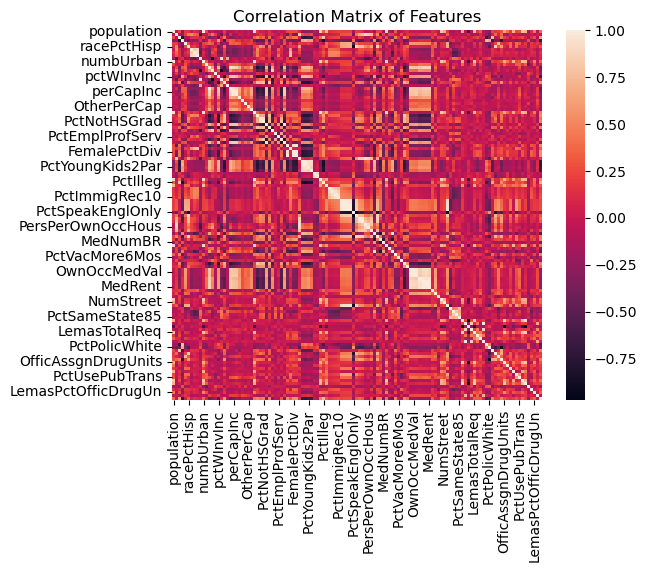

In [12]:
sns.heatmap(data.corr(), cbar=True, square=True)
plt.title("Correlation Matrix of Features")
plt.show()


d. **Calculate the Coefficient of Variation (CV)** for each feature, where $ CV = \frac{s}{m} $ with  $ s $ as the sample standard deviation and $ m $  as the sample mean.


In [13]:
cv = (data.std() / data.mean()) * 100
print(cv)

population             220.350254
householdsize           35.329830
racepctblack           141.092040
racePctWhite            32.378156
racePctAsian           135.916219
                          ...    
LemasPctPolicOnPatr     26.476588
LemasGangUnitDeploy     45.079747
LemasPctOfficDrugUn    255.526600
PolicBudgPerPop         40.278620
ViolentCrimesPerPop     97.901480
Length: 123, dtype: float64



e. **Select features**: Pick $ \lfloor \sqrt{128} \rfloor $ features with the highest CV and make scatter plots and box plots for them. Can you draw conclusions about significance of those features, just by the
scatter plots?


In [14]:
num_features = int(np.sqrt(128))
top_features = cv.sort_values(ascending=False).head(num_features).index
print(top_features)

selected_data = data[top_features] 

Index(['LemasTotalReq', 'NumStreet', 'NumInShelters', 'NumIlleg',
       'LemasSwornFT', 'NumImmig', 'LemasPctOfficDrugUn', 'PctPolicAsian',
       'NumUnderPov', 'population', 'PolicOperBudg'],
      dtype='object')


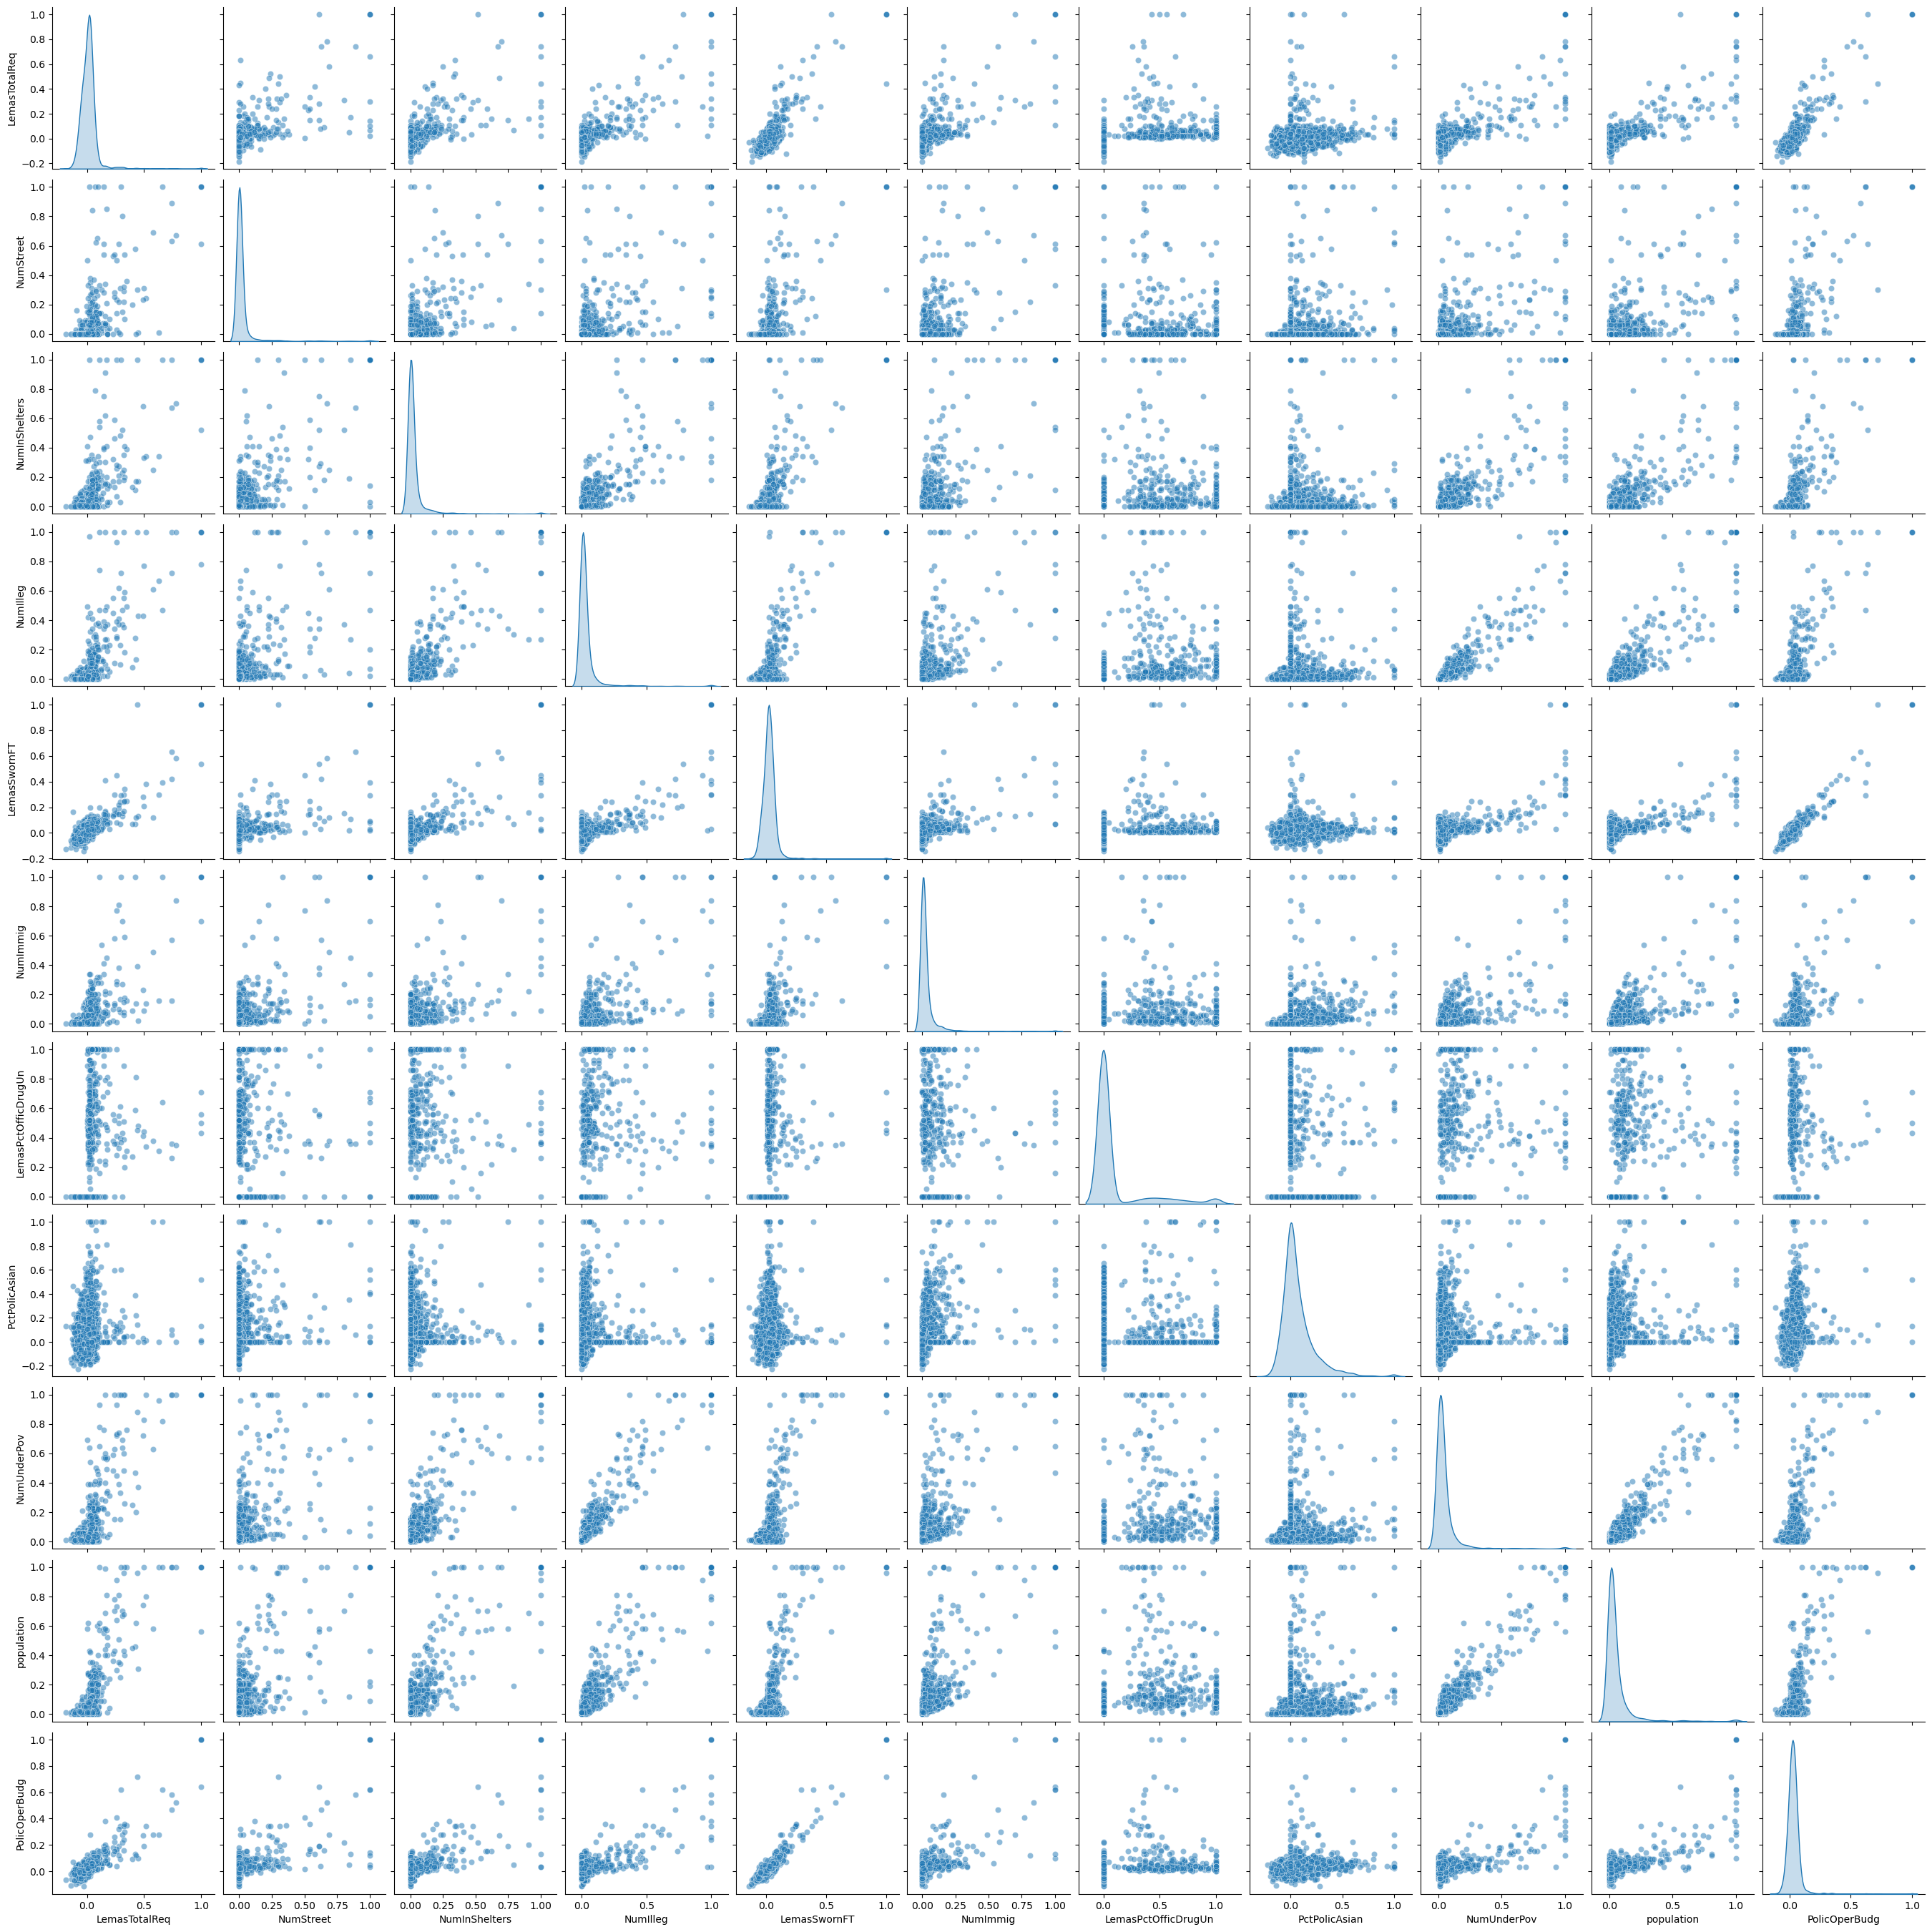

In [15]:
sns.pairplot(selected_data, diag_kind='kde', plot_kws={'alpha': 0.5})
plt.show()

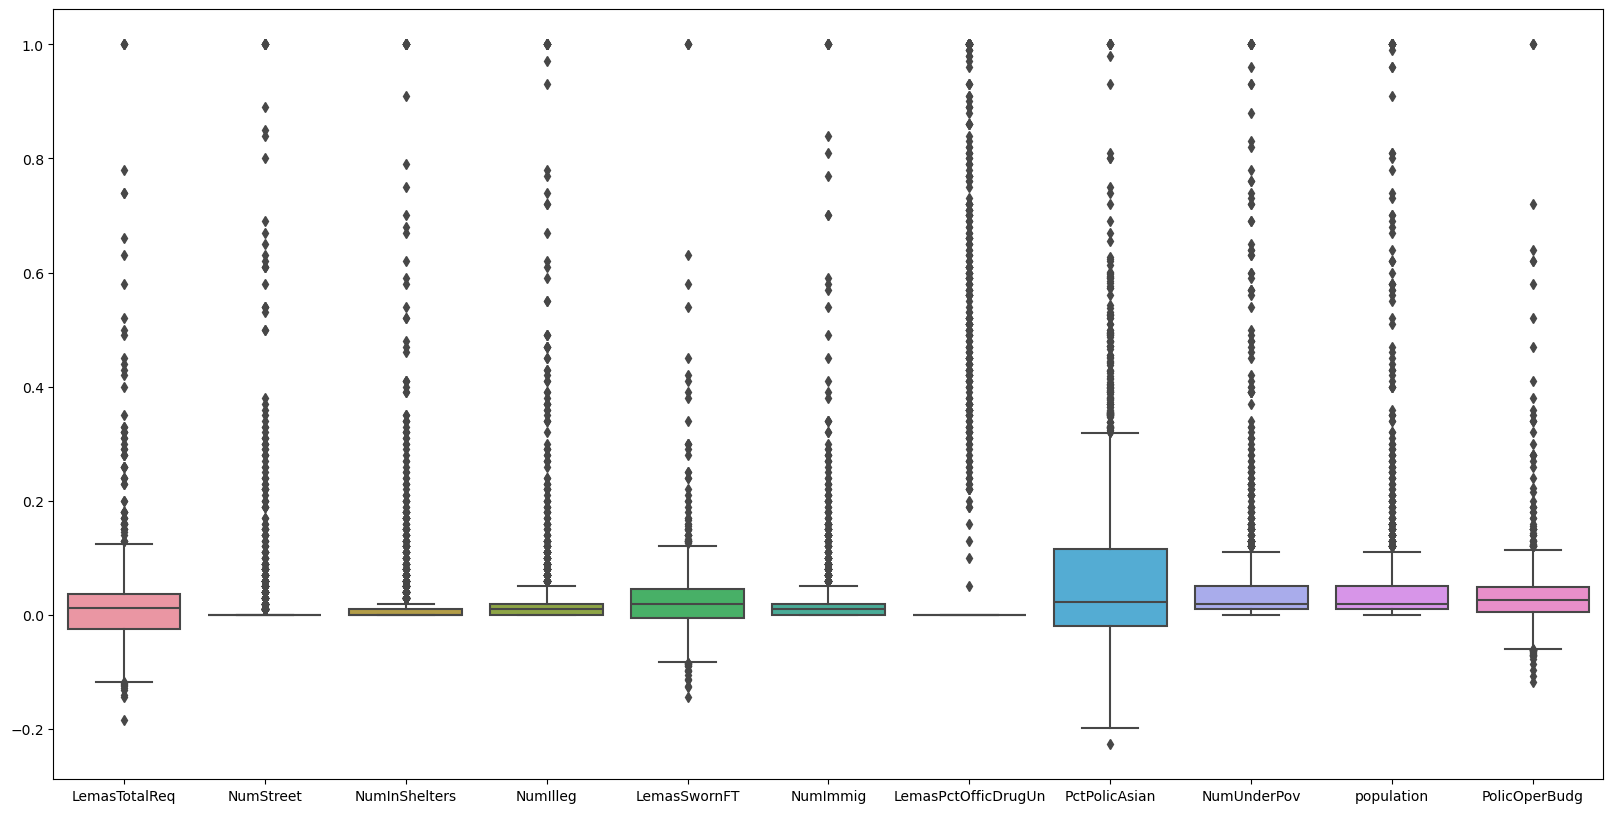

In [16]:
plt.figure(figsize=(20, 10))
sns.boxplot(data=selected_data, orient='v')
plt.show()

We can only know what are the relationships between each pair of features but it lacks of some quantitative assessment such as p-values.


f. **Fit a linear model** using least squares to the training set and report the test error.


In [17]:
training_data = data[:1495]
testing_data = data[1495:]
# print(training_data.shape, testing_data.shape)
X_train = training_data.drop(columns='ViolentCrimesPerPop')
y_train = training_data['ViolentCrimesPerPop']
X_test = testing_data.drop(columns='ViolentCrimesPerPop')
y_test = testing_data['ViolentCrimesPerPop']

In [18]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

y_pred = linear_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error: ', mse)

Mean Squared Error:  0.04145878842804281



g. **Fit a ridge regression model** on the training set with $ \lambda $ chosen by cross-validation. Report the test error obtained.


In [19]:
lambdas = np.linspace(0.0001, 10, 1000)
ridge_model = RidgeCV(alphas=lambdas, cv=5)
ridge_model.fit(X_train, y_train)

best_alpha = ridge_model.alpha_
print('Best alpha: ', best_alpha)

y_pred = ridge_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error: ', mse)

Best alpha:  0.33042702702702703
Mean Squared Error:  0.014765571707753698



h. **Fit a LASSO model** on the training set, with $ \lambda $ chosen by cross-validation. Report the test error and list the variables selected by the model. Repeat with standardized features and compare test errors.


In [20]:
lambdas = np.linspace(0.0001, 100, 1000)
lasso_model = LassoCV(alphas=lambdas, cv=5)
lasso_model.fit(X_train, y_train)

best_alpha = lasso_model.alpha_
print('Best alpha: ', best_alpha)

y_pred = lasso_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error: ', mse)

Best alpha:  0.0001
Mean Squared Error:  0.014892120851704244


In [21]:
feature_coefficients = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lasso_model.coef_
})
selected_features = feature_coefficients[feature_coefficients['Coefficient'] != 0]

with pd.option_context('display.max_rows', None):
    print(selected_features)


                   Feature  Coefficient
2             racepctblack     0.080515
4             racePctAsian    -0.177582
7              agePct12t29    -0.428665
9               agePct65up     0.083001
11                pctUrban     0.004745
13                pctWWage    -0.080705
14            pctWFarmSelf    -0.067280
15              pctWInvInc    -0.219631
16              pctWSocSec     0.025810
17             pctWPubAsst    -0.041550
18              pctWRetire    -0.280581
19               medFamInc     0.026426
21             whitePerCap     0.035176
22             blackPerCap    -0.261213
23            indianPerCap     0.059745
25             OtherPerCap     0.027706
26              HispPerCap     0.138173
27             NumUnderPov    -0.062486
28          PctPopUnderPov    -0.083555
31             PctBSorMore    -0.037215
32           PctUnemployed     0.138273
33               PctEmploy     0.144854
34             PctEmplManu    -0.031355
35         PctEmplProfServ     0.013694


### Standardization

In [22]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)   

lasso_model = LassoCV(alphas=lambdas, cv=5)
lasso_model.fit(X_train_scaled, y_train)

best_alpha = lasso_model.alpha_
print('Best alpha: ', best_alpha)

y_pred = lasso_model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error: ', mse)

Best alpha:  0.0001
Mean Squared Error:  0.014599824871253357


In [23]:
feature_coefficients = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lasso_model.coef_
})

selected_features = feature_coefficients[feature_coefficients['Coefficient'] != 0]

with pd.option_context('display.max_rows', None):
    print(selected_features)

                   Feature  Coefficient
0               population    -0.026440
1            householdsize    -0.019546
2             racepctblack     0.028172
3             racePctWhite     0.004514
4             racePctAsian    -0.040368
5              racePctHisp    -0.035116
6              agePct12t21     0.015039
7              agePct12t29    -0.101821
8              agePct16t24    -0.018809
9               agePct65up     0.036260
11                pctUrban    -0.049221
12               medIncome    -0.007042
13                pctWWage    -0.015644
14            pctWFarmSelf    -0.025066
15              pctWInvInc    -0.046805
16              pctWSocSec    -0.012253
17             pctWPubAsst    -0.028815
18              pctWRetire    -0.048040
21             whitePerCap     0.005458
22             blackPerCap    -0.066338
23            indianPerCap     0.016184
24             AsianPerCap     0.003963
25             OtherPerCap     0.027926
26              HispPerCap     0.034483



i. **Fit a PCR model** on the training set with \( M \) (the number of principal components) chosen by cross-validation. Report the test error obtained.


In [24]:
pcr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('linear_regression', LinearRegression())
])

param_grid = {
    'pca__n_components': np.arange(1, X_train.shape[1] + 1)
}

grid_search = GridSearchCV(estimator=pcr_pipeline, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

best_n_components = grid_search.best_params_['pca__n_components']
print('Best number of components: ', best_n_components)

y_pred = grid_search.predict(X_test)
test_mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error: ', test_mse)

Best number of components:  122
Mean Squared Error:  0.04145878842804357



j. In this section, we would like to fit a boosting tree to the data. As in classification trees, one can use any type of regression at each node to build a multivariate regression tree. Because the number of variables is large in this problem, one can use L1-penalized regression at each node. Such a tree is called L1 penalized gradient boosting tree. You can use XGBoost to fit the model tree. Determine α (the regularization term) using cross-validation.



In [25]:
xgboost_model = XGBRegressor(objective='reg:squarederror')

param_grid = {
    'alpha': np.linspace(0.01, 10, 100),
}

grid_search = GridSearchCV(estimator=xgboost_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

best_alpha = grid_search.best_params_['alpha']
print('Best alpha: ', best_alpha)

y_pred = grid_search.predict(X_test)
test_mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error: ', test_mse)

Best alpha:  1.5236363636363637
Mean Squared Error:  0.017044302793340897
